In [50]:
import os 
import cv2 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import albumentations as at
import tensorflow_datasets as tfds  
import json

In [51]:
from tensorflow.keras.models import Model, Sequential, load_model 
from tensorflow.keras.layers import Activation, Input, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler 
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import BatchNormalization 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical, model_to_dot, Sequence 

In [52]:
DATA_DIR = "datasets/"

(train_ds, valid_ds), info = tfds.load("eurosat/rgb", 
                                       split=["train[:80%]", "train[80%:]"],
                                       shuffle_files = True, 
                                       as_supervised=True, 
                                       with_info = True, 
                                       data_dir = DATA_DIR)

print(train_ds)
print(valid_ds)

<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [53]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

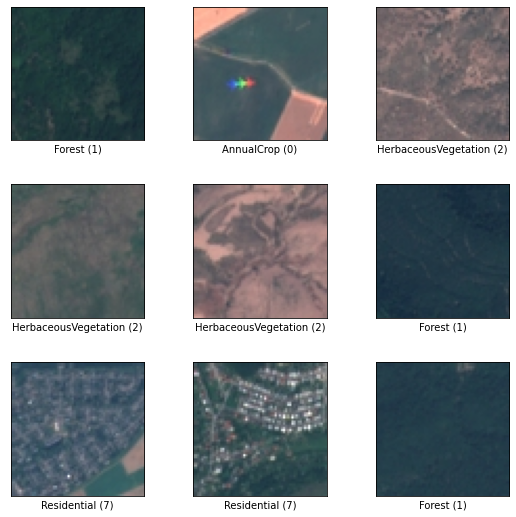

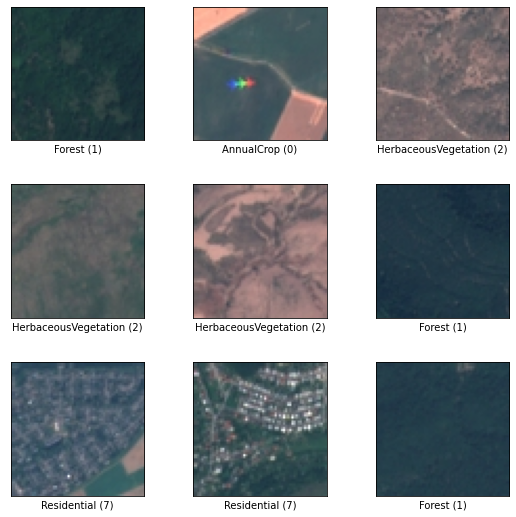

In [54]:
print(info)
tfds.show_examples(train_ds, info)

In [55]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000 

# def get_preprocesses_data(image, label):
#     image = tf.cast(image, tf.float32)/ 255.0 
#     return image, label 

# train_data = train_ds.map(get_preprocesses_data, num_parallel_calls=tf.data.AUTOTUNE)
# valid_data = valid_ds.map(get_preprocesses_data, num_parallel_calls=tf.data.AUTOTUNE)

# train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# valid_data = valid_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [56]:
def create_model():
    model  = Sequential([
                         BatchNormalization(),
                         Conv2D(32, (3, 3), padding="same", activation="relu"),
                         MaxPooling2D(2, 2),
                         BatchNormalization(),
                         Conv2D(64, (3, 3), padding="same", activation="relu"),
                         MaxPooling2D(2, 2),
                         Flatten(),
                         Dense(128, activation="relu"),
                         Dropout(0.3),
                         Dense(64, activation="relu"),
                         Dropout(0.3),
                         Dense(NUM_CLASSES, activation="softmax")
    ])

    return model 

model = create_model()

,image,label
0,,2 (HerbaceousVegetation)
1,,8 (River)
2,,1 (Forest)
3,,3 (Highway)
4,,4 (Industrial)
5,,0 (AnnualCrop)
6,,0 (AnnualCrop)
7,,1 (Forest)
8,,4 (Industrial)
9,,1 (Forest)

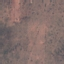
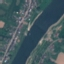
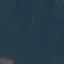
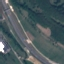
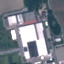
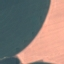
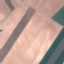
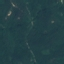
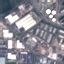
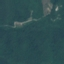

In [57]:
tfds.as_dataframe(valid_ds.take(10), info)

In [58]:
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


Text(0.5, 1.0, 'Highway')

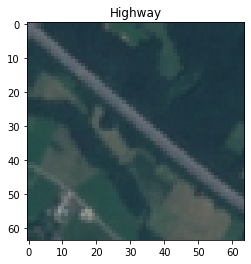

In [59]:
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label))

In [60]:
def get_plot_augmentation(original, augmented):
    fix, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title("Original")

    axes[1].imshow(augmented)
    axes[1].set_title("Augmented")

    plt.show()

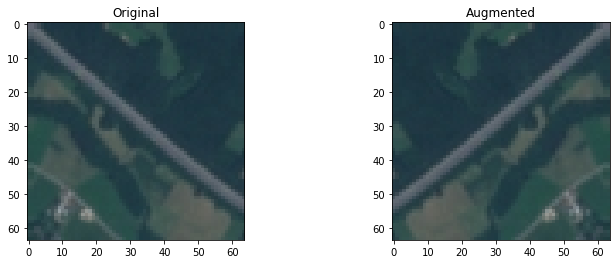

In [61]:
lr_flip = tf.image.flip_left_right(image)
get_plot_augmentation(image, lr_flip)

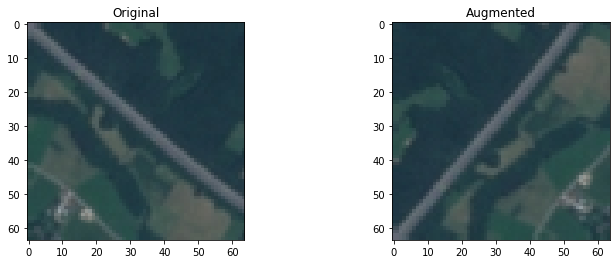

In [62]:
rotate90 = tf.image.rot90(image)
get_plot_augmentation(image, rotate90)

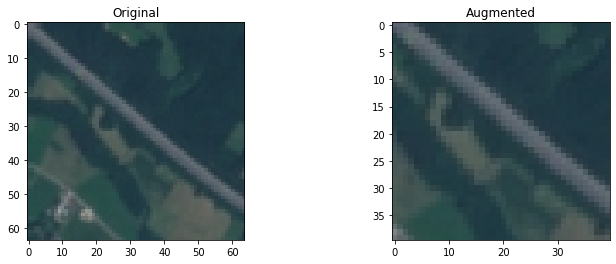

In [63]:
crop = tf.image.central_crop(image, central_fraction=0.6)
get_plot_augmentation(image, crop)

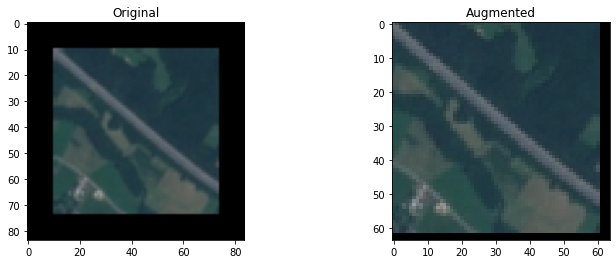

In [64]:
image2 = tf.image.resize_with_crop_or_pad(image, 64+20 , 64+20)
crop2 = tf.image.random_crop(image2, size=[64, 64, 3])
get_plot_augmentation(image2, crop2) 

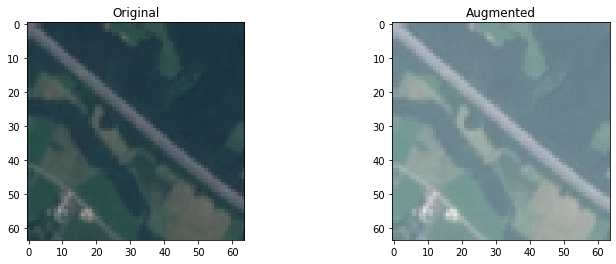

In [65]:
brigntness = tf.image.adjust_brightness(image, delta=0.3)
get_plot_augmentation(image, brigntness)

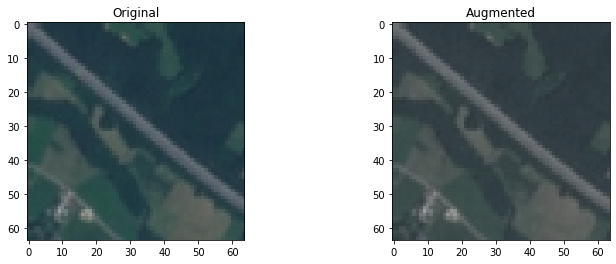

In [66]:
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
get_plot_augmentation(image, saturation)

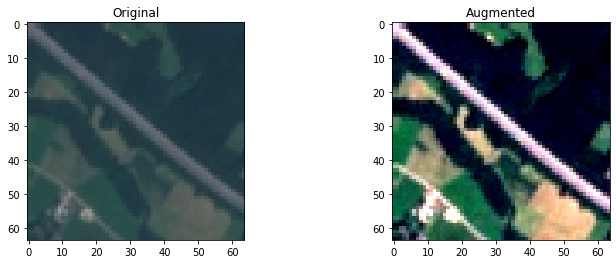

In [67]:
constrast = tf.image.adjust_contrast(image, contrast_factor=5)
get_plot_augmentation(image, constrast)

In [68]:
def get_data_augmentation2(image, labels):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.cast(image, tf.float32)

    return image, labels

train_aug = train_ds.map(get_data_augmentation2, num_parallel_calls=tf.data.AUTOTUNE) 
valid_aug = valid_ds.map(get_data_augmentation2, num_parallel_calls=tf.data.AUTOTUNE)    

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [69]:
aug_model = create_model()

aug_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

aug_history = aug_model.fit(train_aug,
                            validation_data = valid_aug,
                            epochs=50)

aug_model.save("./ex06.h6")

Epoch 1/50
338/338 [==============================] - 12s 29ms/step - loss: 1.8891 - accuracy: 0.2847 - val_loss: 1.6527 - val_accuracy: 0.4230
Epoch 2/50
338/338 [==============================] - 8s 23ms/step - loss: 1.5660 - accuracy: 0.3886 - val_loss: 1.3053 - val_accuracy: 0.5224
Epoch 3/50
338/338 [==============================] - 8s 24ms/step - loss: 1.4418 - accuracy: 0.4385 - val_loss: 1.2237 - val_accuracy: 0.5604
Epoch 4/50
338/338 [==============================] - 8s 23ms/step - loss: 1.3447 - accuracy: 0.4890 - val_loss: 1.1981 - val_accuracy: 0.5709
Epoch 5/50
338/338 [==============================] - 8s 23ms/step - loss: 1.2592 - accuracy: 0.5256 - val_loss: 1.0497 - val_accuracy: 0.6196
Epoch 6/50
338/338 [==============================] - 8s 24ms/step - loss: 1.2160 - accuracy: 0.5453 - val_loss: 1.1409 - val_accuracy: 0.5967
Epoch 7/50
338/338 [==============================] - 8s 23ms/step - loss: 1.1579 - accuracy: 0.5671 - val_loss: 0.9075 - val_accuracy: 0.697

INFO:tensorflow:Assets written to: ./ex06.h6/assets


In [70]:
def get_show_plot_loss(history, epoch):
    loss, val_loss  = history.history["loss"], history.history["val_loss"]
    acc, val_acc = history.history["accuracy"], history.history["val_accuracy"],   
    fig, axes = plt.subplots(1, 2,  figsize=(12, 4))

    axes[0].plot(range(1, epoch+1), loss , label="Training")
    axes[0].plot(range(1, epoch+1), val_loss, label="Validation")
    axes[0].legend(loc="best")
    axes[0].set_title("Loss")

    axes[1].plot(range(1, epoch +1), acc, label="Training")
    axes[1].plot(range(1, epoch +1), val_acc, label="Validation")
    axes[1].legend(loc="best")
    axes[1].set_title("Accuracy")

    plt.show()

    

In [ ]:
get_show_plot_loss(aug_history, 50)